In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

## 4.1 Store Information

In [5]:
stores =pd.read_csv('stores.csv')

In [6]:
stores.shape

(54, 5)

In [7]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
print(f'number of states: {stores.state.nunique()}')
print(f'number of cities: {stores.city.nunique()}')

number of states: 16
number of cities: 22


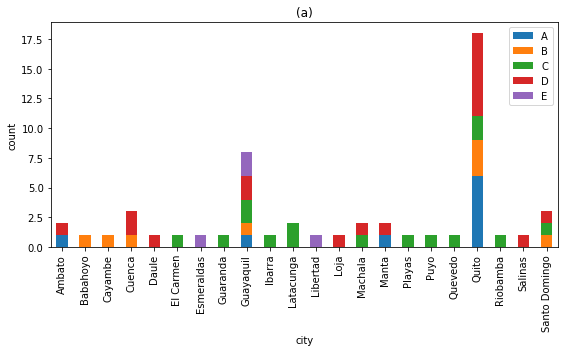

In [9]:
plot_df = stores.groupby(["city", "type"])['store_nbr'] \
    .size() \
    .rename(columns={'type': 'type_count'}) \
    .unstack(level=1) \
    .fillna(0)
plot_df.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.legend()
plt.ylabel("count")
plt.title('(a)')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/city_store.png');

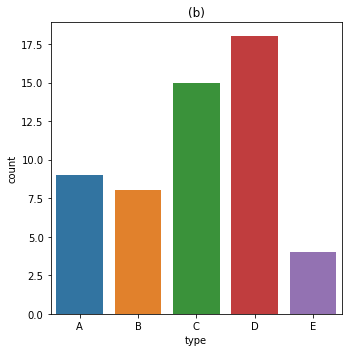

In [10]:
plt.figure(figsize=(5,5))
type_order = np.sort(stores.type.unique())
sns.countplot(data=stores,x = 'type',order=type_order)
plt.title('(b)')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/store_type.png');

''

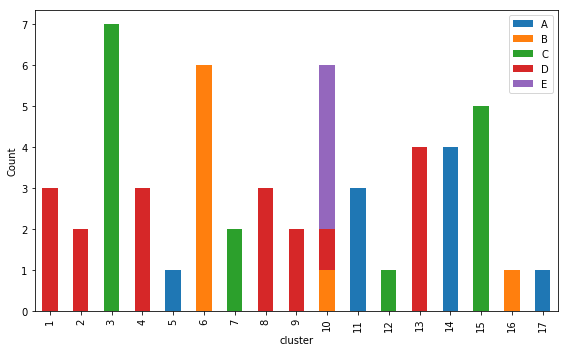

In [11]:
plot_df = stores.groupby(["cluster", "type"])['store_nbr'] \
    .size() \
    .rename(columns={'type': 'type_count'}) \
    .unstack(level=1) \
    .fillna(0)
plot_df.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.legend()
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('milestone_report_1_figures/store_cluster.png')
;

In [58]:
#Create Dictionary for information in stores dataset

state_city_dict = {}
for state in stores.state.unique():
    state_city_dict[state] = set(stores.loc[stores.state == state,'city'])
    
state_store_dict = {}
for state in stores.state.unique():
    state_store_dict[state] = list(stores.loc[stores.state == state,'store_nbr'])
    
city_store_dict = {}
for city in stores.city.unique():
    city_store_dict[city] = set(stores.loc[stores.city == city, 'store_nbr'])

store_type_dict = {}
for store, type_ in zip(stores.store_nbr, stores.type):
    store_type_dict[store] = type_

## 4.2 Item Information

In [13]:
items = pd.read_csv('items.csv')

In [14]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [15]:
items.shape

(4100, 4)

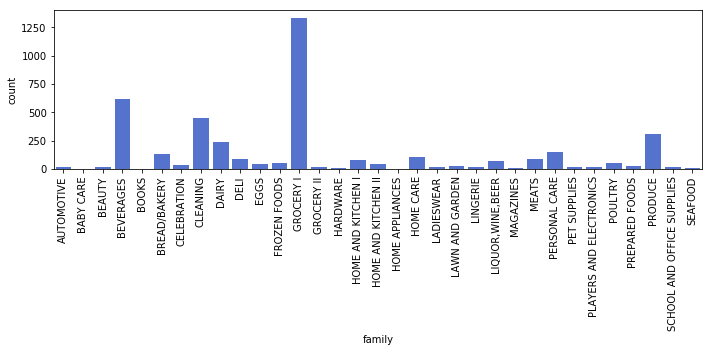

In [30]:
plt.figure(figsize=(10,5))
family_order = np.sort(items.family.unique())
sns.countplot(x=items.family,color='royalblue', order = family_order)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('milestone_report_1_figures/items_family.png');

In [17]:
family_item_dict = {}
for family in items.family.unique():
    family_item_dict[family] = list(items.loc[items.family == family, 'item_nbr'] )

In [27]:
# sns.countplot(data=items, x='perishable');

In [19]:
non_perishable_family = items[items.perishable == 0].groupby(['family'])['item_nbr'].size().index
non_perishable_family

Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'CELEBRATION', 'CLEANING', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
       'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
       'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN',
       'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS',
       'SCHOOL AND OFFICE SUPPLIES'],
      dtype='object', name='family')

In [20]:
perishable_family = items[items.perishable == 1].groupby(['family'])['item_nbr'].size().index
perishable_family

Index(['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'MEATS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')

## 4.3 Oil Price

In [135]:
oil = pd.read_csv('oil.csv',parse_dates = ['date']).set_index('date')

In [136]:
begin_date = oil.index.min()
end_date = oil.index.max()
oil = oil.reindex(pd.date_range(begin_date, end_date), fill_value=np.nan)

In [139]:
oil[oil.dcoilwtico == oil.dcoilwtico.max()]

,dcoilwtico
2013-09-06,110.62


In [41]:
oil[oil.dcoilwtico == oil.dcoilwtico.min()]

,dcoilwtico
2016-02-11,26.19


''

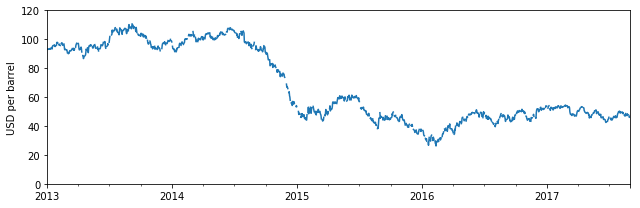

In [26]:
ax = oil.plot(figsize=(9,3))
ax.set_ylim([0,120])
ax.get_legend().remove()
ax.set_ylabel('USD per barrel')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/oil.png')
;

## 4.4 Holiday Data

In [42]:
holidays = pd.read_csv('holidays_events.csv',date_parser='date')

In [43]:
holidays.date =  pd.to_datetime(holidays.date)

In [44]:
holidays['year'] = holidays.date.dt.year
holidays['month'] = holidays.date.dt.month
holidays['day'] = holidays.date.dt.day
holidays['weekday'] = holidays.date.dt.weekday

In [48]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'], dtype=object)

In [ ]:
np.sort(holidays.locale_name.unique())

In [ ]:
np.sort(holidays.locale.unique())

In [ ]:
np.sort(holidays.type.unique())

In [ ]:
quito_holidays = holidays.loc[(holidays.locale_name == 'Quito')|(holidays.locale_name =='Ecuador')]

# 4.5 Train Data

##### Plot Functions

In [141]:
def zoom_in_plot(family,store_plot_list, begin_date = '2013-01-01', end_date = '2017-08-15', title=False): 
    
    if len(store_plot_list) == 1:
        n_col = 1
    else:
        n_col = 2
    n_row = int(np.ceil(np.divide(len(store_plot_list),n_col)))
    f, axes = plt.subplots(n_row, n_col, figsize = (15,n_row*3.5))

    for ax, nbr in zip(axes.flat,store_plot_list):
        date_filter = (city_sales_df[nbr].index >= begin_date) & (city_sales_df[nbr].index <= end_date)
        family_filter = city_sales_df[nbr].family == family    

        ax.plot(city_sales_df[nbr].loc[family_filter & date_filter, 'unit_sales'].resample('D').sum().fillna(0))
        ax.set_title('Store #' + str(nbr) + ' (Type' + store_type_dict[nbr]+ ')')
        ax.set_xlim([begin_date,end_date])
        if title:
            ax.set_title('Sum of Unit Sales of ' + family + ' in Store #' + str(nbr) + ' (Type ' + store_type_dict[nbr] + ')');
    f.tight_layout()

In [83]:
def family_plot(store_list, family, fixed_ylim=False, y_min = 0, y_max=1000000, 
                begin_date='2013-01-01',end_date='2017-08-15', 
                earthquake_line = False, christmas_line=False, freq='W'):

    n_col = 2
    n_row = int(np.ceil(np.divide(len(store_list),n_col)))
    f, axes = plt.subplots(n_row,n_col, figsize = (15,n_row * 3))
    for ax,nbr in zip(axes.flat,store_list):
        ax.plot(city_sales_df[nbr].loc[city_sales_df[nbr].family == family, 'unit_sales'].resample(freq).sum().fillna(0))
        if earthquake_line:
            ax.axvline('2016-04-16', alpha=0.5, color='r',linestyle='--')
        if christmas_line:
            ax.axvline('2016-12-25', alpha=0.5, color='green',linestyle='--')
            ax.axvline('2015-12-25', alpha=0.5, color='green',linestyle='--')
            ax.axvline('2014-12-25', alpha=0.5, color='green',linestyle='--')
            ax.axvline('2013-12-25', alpha=0.5, color='green',linestyle='--')

        ax.set_title('Store #' + str(nbr) + ' (Type' + store_type_dict[nbr]+ ')')
        ax.set_xlim([begin_date,end_date])
        if fixed_ylim:
            ax.set_ylim([y_min,y_max])
        ax.set_ylabel('sum of unit sales in family')
    #f.suptitle('Sum of Unit Sales of ' + family + ' items (Weekly Aggregate)', y=1.01,fontsize=20)
    f.tight_layout()

In [91]:
def family_weekday_boxplot(family,store_plot_list):
    n_col = 2
    n_row = int(np.ceil(np.divide(len(store_plot_list),n_col)))
    plt.figure(figsize= (12,n_row*3))
    for i, nbr in enumerate(store_plot_list,1):
        plt.subplot(n_row,n_col,i)
        temp = city_sales_df[nbr].loc[city_sales_df[nbr].family == family]
        temp = temp.groupby(temp.index)[['unit_sales','weekday']].aggregate({'unit_sales': sum,'weekday':max})
        sns.boxplot(data=temp, x='weekday', y ='unit_sales', 
                    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
        plt.title('Store #' + str(nbr) + ' (Type ' + store_type_dict[nbr] +')')
    plt.tight_layout()

### Read Data

In [53]:
train = pd.read_csv('train.csv',parse_dates=['date'], dtype={'onpromotion':'bool'},index_col = 'id', na_values='NaN')

C:\Users\georg\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\georg\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [54]:
train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
0,2013-01-01,25,103665,7.0,NaN
1,2013-01-01,25,105574,1.0,NaN
2,2013-01-01,25,105575,2.0,NaN
3,2013-01-01,25,108079,1.0,NaN
4,2013-01-01,25,108701,1.0,NaN


In [55]:
train.shape

(125497040, 5)

In [56]:
train.onpromotion.value_counts(dropna=False)

False    96028767
NaN      21657651
True      7810622
Name: onpromotion, dtype: int64

In [142]:
city_store_list = [1,3,9,10,45,46]
city_store_list, len(city_store_list)

([1, 3, 9, 10, 45, 46], 6)

In [61]:
city_sales_df = {}
weekday_map = {6:'Sunday',0:'Monday',1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday'}


for nbr in city_store_list:
    temp_df = train.loc[train.store_nbr == nbr]
    temp_df['year'] = temp_df.date.dt.year
    temp_df['month'] = temp_df.date.dt.month
    temp_df['day'] = temp_df.date.dt.day
    temp_df['weekday'] = temp_df.date.dt.weekday
    temp_df['weekday'] = temp_df['weekday'].map(weekday_map)
    temp_df = temp_df.merge(items, how='left',on='item_nbr')
    temp_df.set_index('date', inplace=True)
    city_sales_df[nbr] = temp_df
    del temp_df; gc.collect()

C:\Users\georg\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\georg\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\georg\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

### 4.5.1 GROCERY I items

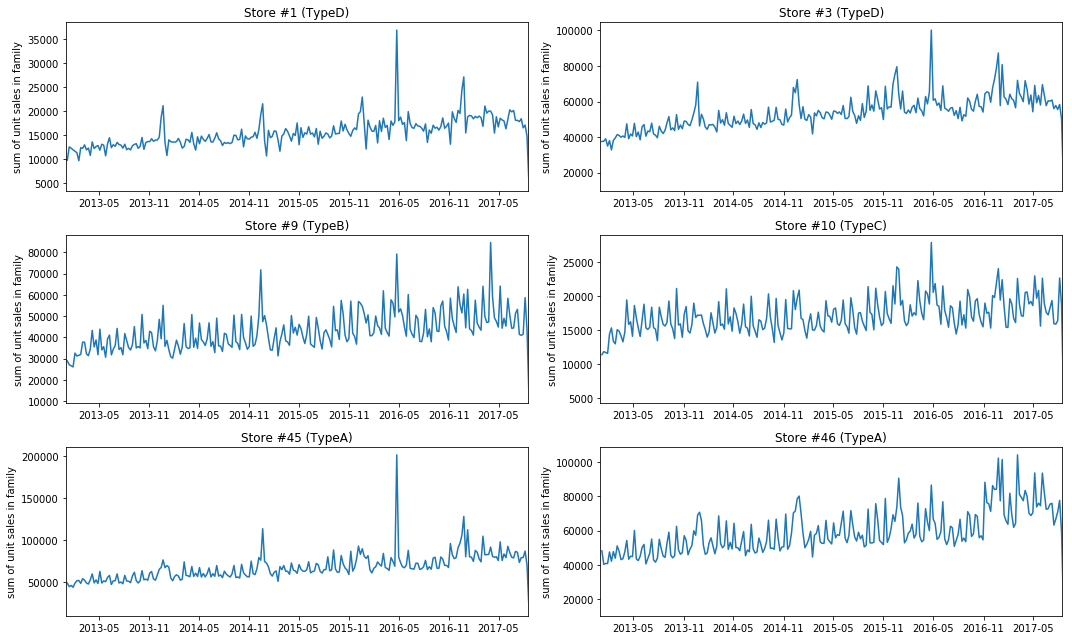

In [143]:
family_plot(city_store_list, family='GROCERY I', earthquake_line=False, christmas_line=False)
plt.savefig('milestone_report_1_figures/GROCERY_time_series.png');

#### 4.5.1.1 Effect of Day of the week

In [224]:
city_store_list

[1, 3, 9, 10, 45, 46]

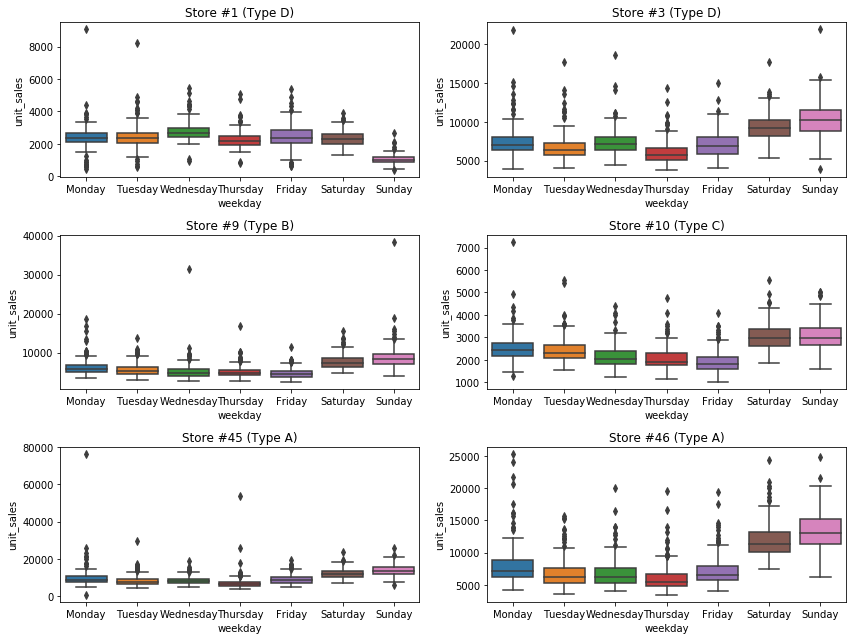

In [229]:
n_col = 2
n_row = int(np.ceil(np.divide(len(city_store_list),n_col)))
family = 'GROCERY I'
plt.figure(figsize= (12,n_row*3))
for i, nbr in enumerate(city_store_list,1):
    plt.subplot(n_row,n_col,i)
    temp = city_sales_df[nbr].loc[city_sales_df[nbr].family == family]
    temp = temp.groupby(temp.index)[['unit_sales','weekday']].aggregate({'unit_sales': sum,'weekday':max})
    sns.boxplot(data=temp, x='weekday', y ='unit_sales', 
                order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.title('Store #' + str(nbr) + ' (Type ' + store_type_dict[nbr] +')')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/grocery_weekday_boxplot.png')

#### 4.5.1.2 Effect of Holidays and Events 

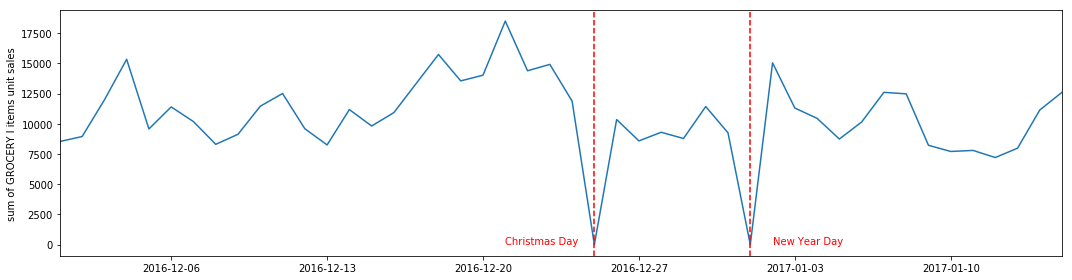

In [197]:
begin_date = '2016-12-01'
end_date= '2017-01-15'
store_nbr = 3

date_filter = (city_sales_df[store_nbr].index >= begin_date) & (city_sales_df[store_nbr].index <= end_date)
family_filter = city_sales_df[store_nbr].family == 'GROCERY I'    

f, ax = plt.subplots(figsize=(15,4))
ax.plot(city_sales_df[store_nbr].loc[family_filter & date_filter, 'unit_sales'].resample('D').sum().fillna(0))
ax.set_ylabel('sum of GROCERY I items unit sales')
ax.set_xlim([begin_date,end_date]);
ax.axvline('2016-12-25',color='red',linestyle='--')
ax.axvline('2017-01-01',color='red',linestyle='--')
ax.annotate('Christmas Day',['2016-12-21',0],color='red')
ax.annotate('New Year Day',['2017-01-02',0],color='red')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/GROCERY_I_christmas.png');

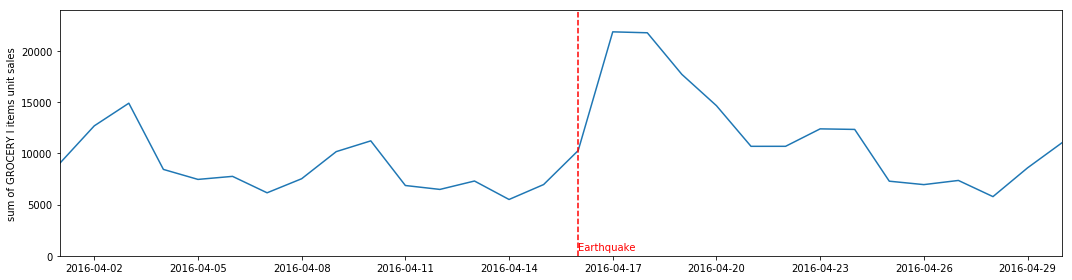

In [223]:
begin_date = '2016-04-01'
end_date= '2016-04-30'
store_nbr = 3

date_filter = (city_sales_df[store_nbr].index >= begin_date) & (city_sales_df[store_nbr].index <= end_date)
family_filter = city_sales_df[store_nbr].family == 'GROCERY I'    

f, ax = plt.subplots(figsize=(15,4))
ax.plot(city_sales_df[store_nbr].loc[family_filter & date_filter, 'unit_sales'].resample('D').sum().fillna(0))
ax.set_ylabel('sum of GROCERY I items unit sales')
ax.set_xlim([begin_date,end_date]);
ax.set_ylim([0,24000]);
ax.axvline('2016-04-16',color='red',linestyle='--')
ax.annotate('Earthquake',['2016-04-16',500],color='red')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/GROCERY_I_earthquake.png');

### 4.5.2 LIQUOR, WINE, BEER

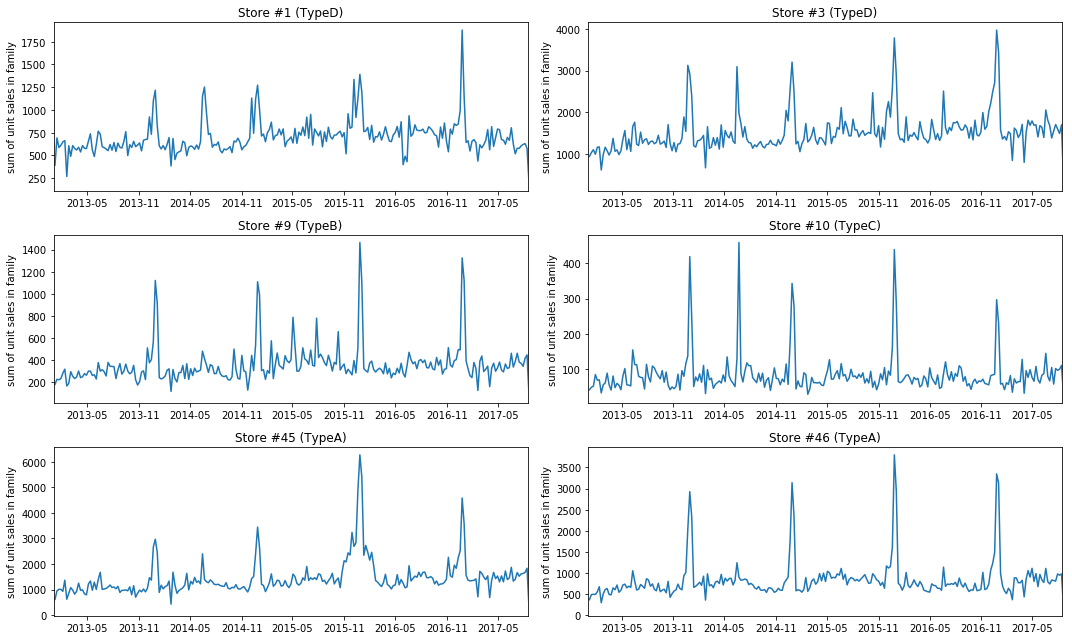

In [233]:
family_plot(city_store_list, 'LIQUOR,WINE,BEER')
plt.savefig('milestone_report_1_figures/LIQUOR_time_series.png')

#### 4.5.2.1 Effect of holidays and events

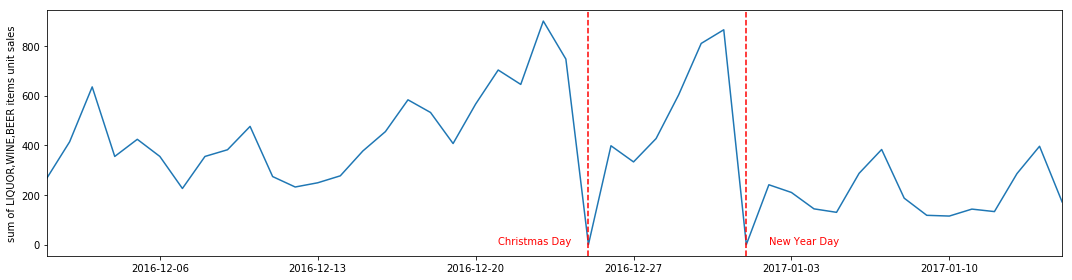

In [237]:
begin_date = '2016-12-01'
end_date= '2017-01-15'
store_nbr = 3
family = 'LIQUOR,WINE,BEER'
date_filter = (city_sales_df[store_nbr].index >= begin_date) & (city_sales_df[store_nbr].index <= end_date)
family_filter = city_sales_df[store_nbr].family == family  

f, ax = plt.subplots(figsize=(15,4))
ax.plot(city_sales_df[store_nbr].loc[family_filter & date_filter, 'unit_sales'].resample('D').sum().fillna(0))
ax.set_ylabel('sum of LIQUOR,WINE,BEER items unit sales')
ax.set_xlim([begin_date,end_date]);
ax.axvline('2016-12-25',color='red',linestyle='--')
ax.axvline('2017-01-01',color='red',linestyle='--')
ax.annotate('Christmas Day',['2016-12-21',0],color='red')
ax.annotate('New Year Day',['2017-01-02',0],color='red')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/LIQUOR_christmas.png');

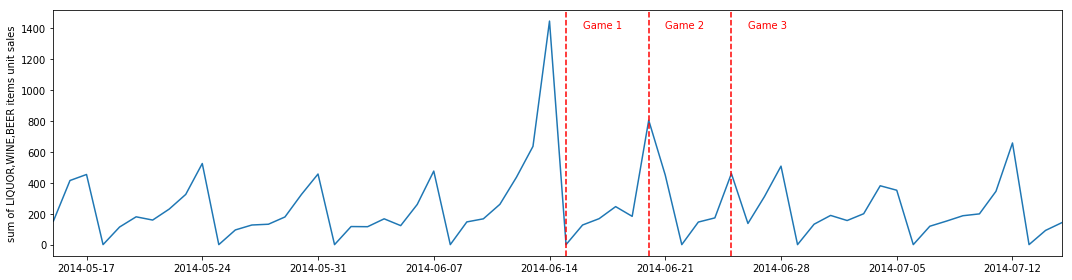

In [241]:
begin_date = '2014-05-15'
end_date= '2014-07-15'
store_nbr = 3
family = 'LIQUOR,WINE,BEER'
date_filter = (city_sales_df[store_nbr].index >= begin_date) & (city_sales_df[store_nbr].index <= end_date)
family_filter = city_sales_df[store_nbr].family == family  

f, ax = plt.subplots(figsize=(15,4))
ax.plot(city_sales_df[store_nbr].loc[family_filter & date_filter, 'unit_sales'].resample('D').sum().fillna(0))
ax.set_ylabel('sum of LIQUOR,WINE,BEER items unit sales')
ax.set_xlim([begin_date,end_date]);
ax.axvline('2014-06-15',color='red',linestyle='--')
ax.axvline('2014-06-20',color='red',linestyle='--')
ax.axvline('2014-06-25',color='red',linestyle='--')
ax.annotate('Game 1',['2014-06-16',1400],color='red')
ax.annotate('Game 2',['2014-06-21',1400],color='red')
ax.annotate('Game 3',['2014-06-26',1400],color='red')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/LIQUOR_worldcup.png');

### 4.5.3 PRODUCE

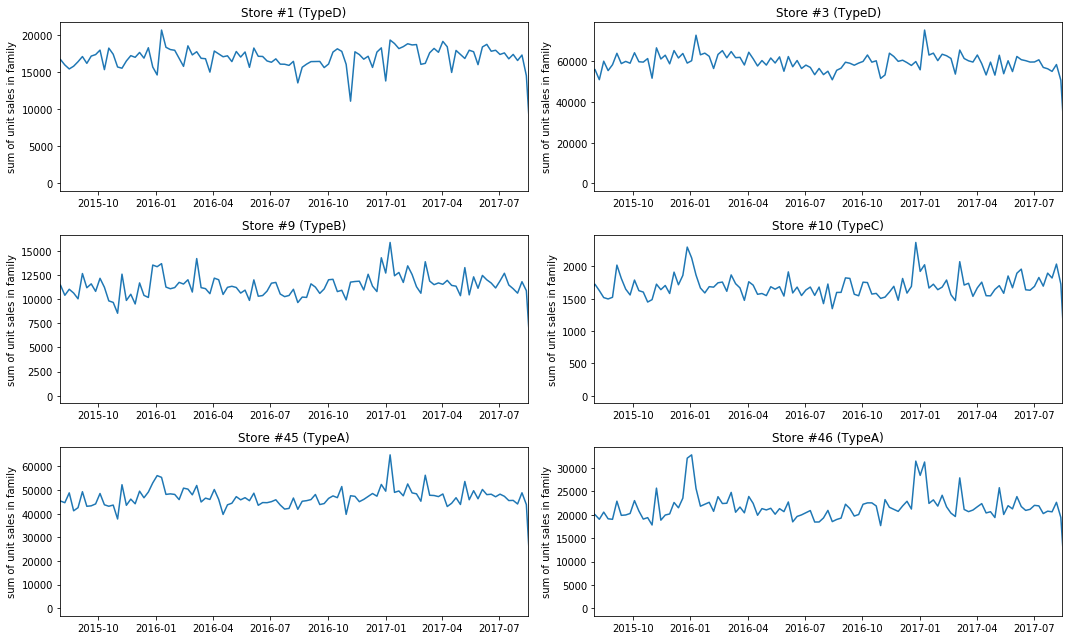

In [243]:
family_plot(city_store_list, 'PRODUCE', begin_date = '2015-08-01')
plt.savefig('milestone_report_1_figures/PRODUCE_time_series.png')

#### 4.5.3.1 Effect of Holidays and Events

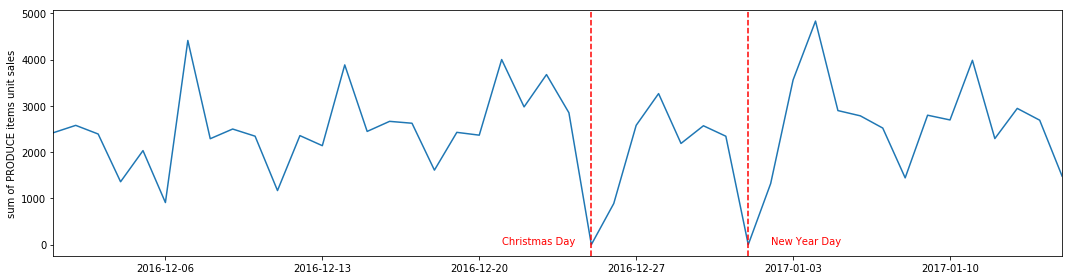

In [249]:
begin_date = '2016-12-01'
end_date= '2017-01-15'
store_nbr = 1
family = 'PRODUCE'
date_filter = (city_sales_df[store_nbr].index >= begin_date) & (city_sales_df[store_nbr].index <= end_date)
family_filter = city_sales_df[store_nbr].family == family  

f, ax = plt.subplots(figsize=(15,4))
ax.plot(city_sales_df[store_nbr].loc[family_filter & date_filter, 'unit_sales'].resample('D').sum().fillna(0))
ax.set_ylabel('sum of PRODUCE items unit sales')
ax.set_xlim([begin_date,end_date]);
ax.axvline('2016-12-25',color='red',linestyle='--')
ax.axvline('2017-01-01',color='red',linestyle='--')
ax.annotate('Christmas Day',['2016-12-21',0],color='red')
ax.annotate('New Year Day',['2017-01-02',0],color='red')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/PRODUCE_christmas.png');

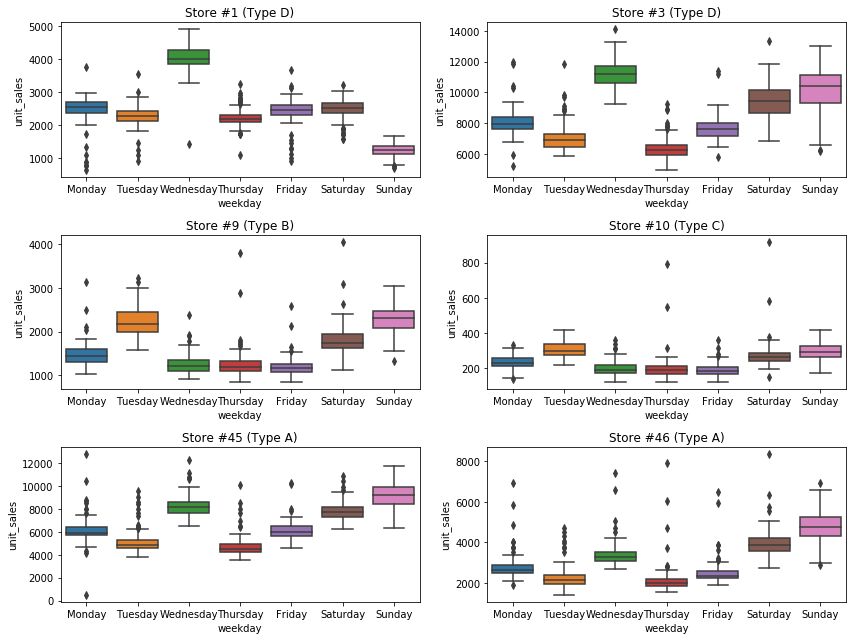

In [251]:
n_col = 2
n_row = int(np.ceil(np.divide(len(city_store_list),n_col)))
family = 'PRODUCE'

begin_date = '2015-08-01'
end_date ='2017-08-15'

plt.figure(figsize= (12,n_row*3))
for i, store_nbr in enumerate(city_store_list,1):
    plt.subplot(n_row,n_col,i)
    date_filter = (city_sales_df[store_nbr].index >= begin_date) & (city_sales_df[store_nbr].index <= end_date)
    family_filter = city_sales_df[store_nbr].family == family  
    temp = city_sales_df[store_nbr].loc[family_filter & date_filter, ['unit_sales','weekday']]
    temp = temp.groupby(temp.index)[['unit_sales','weekday']].aggregate({'unit_sales': sum,'weekday':max})
    sns.boxplot(data=temp, x='weekday', y ='unit_sales', 
                order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.title('Store #' + str(store_nbr) + ' (Type ' + store_type_dict[store_nbr] +')')
plt.tight_layout()
plt.savefig('milestone_report_1_figures/grocery_weekday_boxplot.png')